In [8]:
!wget -q https://mklab.iti.gr/uxord/UXORD-10K-release.zip -O UXORD-10K.zip && unzip -q UXORD-10K.zip -d UXORD-10K && rm UXORD-10K.zip

In [2]:
# 1) Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# 2) Pick a destination folder in your Drive
DEST="/content/drive/MyDrive/datasets/UXORD-10K"
!mkdir -p "$DEST"

# 3) Copy the extracted dataset folder into Drive (shows progress)
!rsync -ah --info=progress2 /content/UXORD-10K/ "$DEST"/


Process is terminated.


Tip for next time: copy from drive, extract and continue (if connection halted suddenly)

In [7]:
SRC="/content/drive/MyDrive/datasets/UXORD-10K"; \
DST="/content/UXORD-10K"; \
mkdir -p "$DST" && (cd "$SRC" && zip -q -r /content/UXORD-10K.tmp.zip .) && \
unzip -q /content/UXORD-10K.tmp.zip -d "$DST" && \
rm /content/UXORD-10K.tmp.zip && \
echo "Copied to $DST"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
^C
unzip:  cannot find or open /content/UXORD-10K.tmp.zip, /content/UXORD-10K.tmp.zip.zip or /content/UXORD-10K.tmp.zip.ZIP.
rm: cannot remove '/content/UXORD-10K.tmp.zip': No such file or directory


## YOLOv8 implementation:

In [4]:
# YOLOv8 (classification) on UXORD-10K — end-to-end single cell
# - Loads folder-structured dataset (train/val/test with class subfolders)
# - Trains YOLOv8n-cls (tiny) with transfer learning
# - Evaluates on the test split (Top-1/Top-5, confusion matrix, per-class P/R/F1)
# - Plots training curves and confusion matrix
# - Saves best weights and (optionally) ONNX export
#
# Assumes dataset at: /content/UXORD-10K/UXORD-10K-release/no-logos
# Folder layout must be:
#   no-logos/
#     train/<class>/*.jpg
#     val/<class>/*.jpg
#     test/<class>/*.jpg

import os, sys, subprocess, time, random, glob, json, pathlib, warnings
warnings.filterwarnings("ignore")

# ---------- Install deps (works in Colab/Notebook/Python) ----------
def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", *pkgs, "-q"])

pip_install(["ultralytics>=8.3.0", "torch>=2.1.0", "torchvision>=0.16.0", "scikit-learn", "pandas", "matplotlib"])

# ---------- Imports ----------
import torch
from ultralytics import YOLO
from ultralytics.utils import SETTINGS
from ultralytics.utils.files import increment_path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, top_k_accuracy_score
import matplotlib.pyplot as plt

# ---------- Config ----------
DATASET_DIR = "/content/UXORD-10K/UXORD-10K-release/no-logos"  # <-- change if needed
IMG_SIZE = 224                 # YOLOv8-cls default
EPOCHS = 40                    # increase if you have more time/GPU
BATCH = 32                     # tune based on VRAM
PATIENCE = 10                  # early stopping
LR0 = 1e-3                     # initial LR (AdamW)
WEIGHT_DECAY = 5e-4
RUN_NAME = "uxord10k_yolov8n_cls"
MODEL_WEIGHTS = "yolov8n-cls.pt"  # tiny + fast
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
EXPORT_ONNX = False            # set True to export ONNX at the end

# Determinism
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Make Ultralytics quiet and offline-friendly
SETTINGS.update({"sync": False, "tensorboard": False, "clearml": False})

# ---------- Sanity checks ----------
def assert_dataset_ok(root):
    assert os.path.isdir(root), f"Dataset folder not found: {root}"
    for split in ["train", "val", "test"]:
        sp = os.path.join(root, split)
        assert os.path.isdir(sp), f"Missing split: {sp}"
        # must contain class subfolders
        subs = [d for d in os.listdir(sp) if os.path.isdir(os.path.join(sp, d))]
        assert len(subs) > 0, f"No class subfolders found under: {sp}"
    return True

assert_dataset_ok(DATASET_DIR)

# Infer classes from train split
train_classes = sorted([d for d in os.listdir(os.path.join(DATASET_DIR, "train"))
                        if os.path.isdir(os.path.join(DATASET_DIR, "train", d))])
NUM_CLASSES = len(train_classes)
print(f"Found {NUM_CLASSES} classes:", train_classes)

# ---------- Train YOLOv8 classification ----------
# Note: YOLO classification expects `data` to point to a dir with train/val(/test) subfolders of class-subdirs.
save_dir = increment_path(pathlib.Path("runs/classify") / RUN_NAME, exist_ok=False)
print(f"Training run will be saved to: {save_dir}")

model = YOLO(MODEL_WEIGHTS)  # loads pretrained ImageNet head/backbone
t0 = time.time()
results = model.train(
    data=DATASET_DIR,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH,
    patience=PATIENCE,
    lr0=LR0,
    optimizer="AdamW",
    weight_decay=WEIGHT_DECAY,
    device=DEVICE,
    name=RUN_NAME,
    verbose=True
)
t_train = time.time() - t0
print(f"Training finished in {t_train/60:.1f} min")

# ---------- Validate on TEST split (Top-1 / Top-5) ----------
print("\nEvaluating on TEST split with YOLO...")
val_metrics = model.val(data=DATASET_DIR, imgsz=IMG_SIZE, batch=BATCH, split="test", device=DEVICE, verbose=False)
# val_metrics returns dict-like; print key summary if available
try:
    m = getattr(val_metrics, "metrics", val_metrics)
    # ultralytics may expose metrics like accuracy_top1, accuracy_top5
    top1 = getattr(m, "top1", None) or m.get("top1", None)
    top5 = getattr(m, "top5", None) or m.get("top5", None)
    if top1 is not None:
        print(f"YOLO test Top-1: {float(top1):.4f}")
    if top5 is not None:
        print(f"YOLO test Top-5: {float(top5):.4f}")
except Exception as e:
    print("Note: could not parse test metrics from YOLO `val()`:", e)

# ---------- Detailed evaluation with sklearn (per-class metrics + confusion matrix) ----------
print("\nCollecting per-image predictions on TEST split for sklearn metrics...")
test_dir = os.path.join(DATASET_DIR, "test")

# Build ground-truth index using ImageFolder
# (We only use it to map filepaths -> integer labels)
eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
])
test_ds = datasets.ImageFolder(test_dir, transform=eval_transform)
class_names = test_ds.classes
assert class_names == train_classes, "Class order mismatch between train and test splits."

# Map absolute path -> label id
gt_map = {}
for img_path, label in test_ds.samples:
    gt_map[os.path.abspath(img_path)] = label

# Use model.predict to stream through test images
y_true, y_pred, y_prob = [], [], []  # prob for top-k accuracy
pred_stream = model.predict(source=test_dir, imgsz=IMG_SIZE, device=DEVICE, stream=True, verbose=False)
for r in pred_stream:
    p = r.probs  # classification probabilities
    if p is None:
        # safety: skip if probs missing
        continue
    # Standardize path key
    path = os.path.abspath(r.path)
    if path not in gt_map:
        # Some environments resolve symlinks differently; try basename match as fallback
        # Build reverse map once
        pass
    y_true.append(gt_map[path])
    y_pred.append(int(p.top1))
    # store probability vector for top-k metrics
    y_prob.append(p.data.tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob) if len(y_prob) == len(y_true) else None

print(f"Evaluated {len(y_true)} test images.")

# Metrics
acc = accuracy_score(y_true, y_pred)
print(f"Sklearn Top-1 accuracy: {acc:.4f}")
if y_prob is not None and y_prob.ndim == 2 and y_prob.shape[1] >= 5:
    acc_top5 = top_k_accuracy_score(y_true, y_prob, k=5, labels=list(range(NUM_CLASSES)))
    print(f"Sklearn Top-5 accuracy: {acc_top5:.4f}")

# Per-class precision/recall/F1
report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("\nPer-class precision/recall/F1:")
print(df_report.round(4).to_string())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
fig_cm, ax_cm = plt.subplots(figsize=(9, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax_cm, xticks_rotation=45, colorbar=True)
ax_cm.set_title("Confusion Matrix — UXORD-10K (Test)")
plt.tight_layout()
cm_path = os.path.join(save_dir, "confusion_matrix.png")
os.makedirs(save_dir, exist_ok=True)
fig_cm.savefig(cm_path, dpi=200)
plt.show()
print(f"Saved confusion matrix to: {cm_path}")

# ---------- Plot training curves from results.csv ----------
def find_latest_train_dir(run_name_prefix="uxord10k_yolov8n_cls"):
    candidates = sorted(glob.glob(os.path.join("runs", "classify", f"{run_name_prefix}*")), key=os.path.getmtime)
    return candidates[-1] if candidates else None

train_dir = find_latest_train_dir(RUN_NAME)
results_csv = os.path.join(train_dir, "results.csv") if train_dir else None

if results_csv and os.path.isfile(results_csv):
    df = pd.read_csv(results_csv)
    # Some versions name columns slightly differently; be defensive:
    # Typical columns: train/loss, val/loss, metrics/accuracy_top1, metrics/accuracy_top5
    keys = df.columns.tolist()

    def plot_metric(col, title, outname):
        if col in df:
            plt.figure(figsize=(7,4))
            plt.plot(df[col])
            plt.xlabel("epoch")
            plt.ylabel(col)
            plt.title(title)
            outp = os.path.join(train_dir, outname)
            plt.tight_layout()
            plt.savefig(outp, dpi=200)
            plt.show()
            print(f"Saved: {outp}")

    # Plot accuracy curves
    for k in ["metrics/accuracy_top1", "metrics/accuracy_top5"]:
        if k in df:
            plot_metric(k, f"{k} over epochs", f"{k.replace('/', '_')}.png")

    # Plot losses
    for k in ["train/loss", "val/loss"]:
        if k in df:
            plot_metric(k, f"{k} over epochs", f"{k.replace('/', '_')}.png")
else:
    print("results.csv not found — skipping curve plots.")

# ---------- Save paths and (optional) ONNX export ----------
# Best weights are under train_dir / weights/best.pt
best_weights = os.path.join(train_dir, "weights", "best.pt") if train_dir else None
last_weights = os.path.join(train_dir, "weights", "last.pt") if train_dir else None
print("\nArtifacts:")
print("  Train dir:   ", train_dir)
print("  Best weights:", best_weights if best_weights and os.path.isfile(best_weights) else "N/A")
print("  Last weights:", last_weights if last_weights and os.path.isfile(last_weights) else "N/A")

if EXPORT_ONNX and best_weights and os.path.isfile(best_weights):
    print("Exporting ONNX...")
    exported = model.export(format="onnx", dynamic=False)
    print("ONNX exported to:", exported)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Found 8 classes: ['aircraft-bombs', 'fuzes', 'grenades', 'landmines', 'mortars', 'projectiles', 'rockets', 'submunitions']
Training run will be saved to: runs/classify/uxord10k_yolov8n_cls
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/UXORD-10K/UXORD-10K-release/no-logos, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=

KeyboardInterrupt: 

In [6]:
# YOLOv8 (classification) on UXORD-10K — single cell with "save on improvement" checkpoints
# - Loads folder-structured dataset (train/val/test with class subfolders)
# - Trains YOLOv8n-cls (tiny) with transfer learning
# - On each epoch end: if Top-1 accuracy improves vs previous epoch, copy weights to ./checkpoints/
# - Evaluates on test split (Top-1/Top-5), prints per-class metrics, plots confusion matrix & curves
# - Saves best weights; optional ONNX export
#
# Assumes dataset at: /content/UXORD-10K/UXORD-10K-release/no-logos
# Layout:
#   no-logos/train/<class>/*.jpg
#   no-logos/val/<class>/*.jpg
#   no-logos/test/<class>/*.jpg

import os, sys, subprocess, time, random, glob, json, pathlib, warnings, shutil
warnings.filterwarnings("ignore")

# ---------- Install deps ----------
def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", *pkgs, "-q"])
pip_install(["ultralytics>=8.3.0", "torch>=2.1.0", "torchvision>=0.16.0", "scikit-learn", "pandas", "matplotlib"])

# ---------- Imports ----------
import torch
from ultralytics import YOLO
from ultralytics.utils import SETTINGS
from ultralytics.utils.files import increment_path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, top_k_accuracy_score
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- Config ----------
DATASET_DIR = "/content/UXORD-10K/UXORD-10K-release/no-logos"  # <-- update if needed
IMG_SIZE = 224                 # YOLOv8-cls default
EPOCHS = 40                    # bump if you have more time/GPU
BATCH = 128                    # tune per VRAM
PATIENCE = 10                  # early stopping
LR0 = 1e-3                     # AdamW LR
WEIGHT_DECAY = 5e-4
RUN_NAME = "uxord10k_yolov8n_cls"
MODEL_WEIGHTS = "yolov8n-cls.pt"  # tiny + fast
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
EXPORT_ONNX = False            # set True to export ONNX after training

# Determinism
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Make Ultralytics quiet/offline-friendly
SETTINGS.update({"sync": False, "tensorboard": False, "clearml": False})

# ---------- Sanity checks ----------
def assert_dataset_ok(root):
    assert os.path.isdir(root), f"Dataset folder not found: {root}"
    for split in ["train", "val", "test"]:
        sp = os.path.join(root, split)
        assert os.path.isdir(sp), f"Missing split: {sp}"
        subs = [d for d in os.listdir(sp) if os.path.isdir(os.path.join(sp, d))]
        assert len(subs) > 0, f"No class subfolders found under: {sp}"
    return True
assert_dataset_ok(DATASET_DIR)

# Infer classes from train split
train_classes = sorted([d for d in os.listdir(os.path.join(DATASET_DIR, "train"))
                        if os.path.isdir(os.path.join(DATASET_DIR, "train", d))])
NUM_CLASSES = len(train_classes)
print(f"Found {NUM_CLASSES} classes:", train_classes)

# ---------- Prepare save dirs ----------
save_dir = increment_path(Path("runs/classify") / RUN_NAME, exist_ok=False)
ckpt_dir = Path("checkpoints"); ckpt_dir.mkdir(parents=True, exist_ok=True)
print(f"Training run will be saved to: {save_dir}")
print(f"Improvement checkpoints will be copied to: {ckpt_dir.resolve()}")

# ---------- Build model ----------
model = YOLO(MODEL_WEIGHTS)  # ImageNet-pretrained classifier

# ---------- Callback: save weights when Top-1 improves ----------
best_acc_holder = {"top1": -float("inf")}  # mutable container for closure
EPS = 1e-12

def _extract_top1(trainer):
    """Try to read current epoch's Top-1 from trainer/validator metrics (robust across minor API changes)."""
    acc = None
    # Prefer validator metrics (post-val)
    validator = getattr(trainer, "validator", None)
    m = getattr(validator, "metrics", None)
    for src in (m, getattr(trainer, "metrics", None)):
        if src is None:
            continue
        if hasattr(src, "top1") and src.top1 is not None:
            try: return float(src.top1)
            except: pass
        if isinstance(src, dict):
            for k in ("top1", "accuracy_top1", "metrics/accuracy_top1"):
                if k in src and src[k] is not None:
                    try: return float(src[k])
                    except: pass
    return acc

def on_epoch_end_save_if_improved(trainer):
    acc = _extract_top1(trainer)
    if acc is None:
        return
    if acc > best_acc_holder["top1"] + EPS:
        best_acc_holder["top1"] = acc
        epoch = getattr(trainer, "epoch", None)
        # Copy the just-updated best.pt (Ultralytics writes it when metric improves)
        weights_dir = Path(trainer.save_dir) / "weights"
        src_best = weights_dir / "best.pt"
        if src_best.exists():
            dst = ckpt_dir / f"{RUN_NAME}_best_epoch{epoch}_top1_{acc:.4f}.pt"
            shutil.copy2(src_best, dst)
            print(f"[checkpoint] ↑ Improved Top-1={acc:.4f} at epoch {epoch}. Saved: {dst}")
        else:
            # fallback: copy last.pt if best isn't present yet
            src_last = weights_dir / "last.pt"
            if src_last.exists():
                dst = ckpt_dir / f"{RUN_NAME}_improved_epoch{epoch}_top1_{acc:.4f}.pt"
                shutil.copy2(src_last, dst)
                print(f"[checkpoint] ↑ Improved Top-1={acc:.4f} at epoch {epoch}. Saved (last): {dst}")

# Register for both hooks to be safe across versions
model.add_callback("on_fit_epoch_end", on_epoch_end_save_if_improved)
model.add_callback("on_train_epoch_end", on_epoch_end_save_if_improved)

# ---------- Train ----------
t0 = time.time()
results = model.train(
    data=DATASET_DIR,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH,
    patience=PATIENCE,
    lr0=LR0,
    optimizer="AdamW",
    weight_decay=WEIGHT_DECAY,
    device=DEVICE,
    name=RUN_NAME,
    verbose=True,
    save_period=0  # we handle improvement saves ourselves; Ultralytics still writes last.pt and best.pt
)
t_train = time.time() - t0
print(f"Training finished in {t_train/60:.1f} min")

# ---------- Evaluate on TEST split (Top-1 / Top-5) ----------
print("\nEvaluating on TEST split with YOLO...")
val_metrics = model.val(data=DATASET_DIR, imgsz=IMG_SIZE, batch=BATCH, split="test", device=DEVICE, verbose=False)
try:
    m = getattr(val_metrics, "metrics", val_metrics)
    top1 = getattr(m, "top1", None) or m.get("top1", None) if isinstance(m, dict) else None
    top5 = getattr(m, "top5", None) or m.get("top5", None) if isinstance(m, dict) else None
    if top1 is not None: print(f"YOLO test Top-1: {float(top1):.4f}")
    if top5 is not None: print(f"YOLO test Top-5: {float(top5):.4f}")
except Exception as e:
    print("Note: could not parse test metrics from YOLO `val()`:", e)

# ---------- Detailed sklearn evaluation on TEST ----------
print("\nCollecting per-image predictions on TEST split...")
test_dir = os.path.join(DATASET_DIR, "test")
eval_transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(IMG_SIZE), transforms.ToTensor()])
test_ds = datasets.ImageFolder(test_dir, transform=eval_transform)
class_names = test_ds.classes
assert class_names == train_classes, "Class order mismatch between train and test splits."

# Build absolute-path -> label map (and a basename fallback)
gt_map = {}
basename_map = {}
for img_path, label in test_ds.samples:
    absp = os.path.abspath(img_path)
    gt_map[absp] = label
    basename_map[os.path.basename(absp)] = label  # fallback only

y_true, y_pred, y_prob = [], [], []

pred_stream = model.predict(source=test_dir, imgsz=IMG_SIZE, device=DEVICE, stream=True, verbose=False)
for r in pred_stream:
    p = r.probs
    if p is None:
        continue
    path = os.path.abspath(r.path)
    label = gt_map.get(path)
    if label is None:
        # fallback to basename (rare; only if absolute paths resolve differently)
        label = basename_map.get(os.path.basename(path))
        if label is None:
            continue
    y_true.append(label)
    y_pred.append(int(p.top1))
    y_prob.append(p.data.tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob) if len(y_prob) == len(y_true) else None
print(f"Evaluated {len(y_true)} test images.")

acc = accuracy_score(y_true, y_pred)
print(f"Sklearn Top-1 accuracy: {acc:.4f}")
if y_prob is not None and y_prob.ndim == 2 and y_prob.shape[1] >= 5:
    acc_top5 = top_k_accuracy_score(y_true, y_prob, k=5, labels=list(range(NUM_CLASSES)))
    print(f"Sklearn Top-5 accuracy: {acc_top5:.4f}")

report = classification_report(y_true, y_pred, target_names=class_names, digits=4, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("\nPer-class precision/recall/F1:")
print(df_report.round(4).to_string())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
fig_cm, ax_cm = plt.subplots(figsize=(9, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax_cm, xticks_rotation=45, colorbar=True)
ax_cm.set_title("Confusion Matrix — UXORD-10K (Test)")
plt.tight_layout()
train_dir = sorted(glob.glob(os.path.join("runs", "classify", f"{RUN_NAME}*")), key=os.path.getmtime)[-1]
os.makedirs(train_dir, exist_ok=True)
cm_path = os.path.join(train_dir, "confusion_matrix.png")
fig_cm.savefig(cm_path, dpi=200)
plt.show()
print(f"Saved confusion matrix to: {cm_path}")

# ---------- Plot training curves from results.csv ----------
results_csv = os.path.join(train_dir, "results.csv")
if os.path.isfile(results_csv):
    df = pd.read_csv(results_csv)

    def plot_metric(col, title, outname):
        if col in df:
            plt.figure(figsize=(7,4))
            plt.plot(df[col])
            plt.xlabel("epoch")
            plt.ylabel(col)
            plt.title(title)
            outp = os.path.join(train_dir, outname)
            plt.tight_layout()
            plt.savefig(outp, dpi=200)
            plt.show()
            print(f"Saved: {outp}")

    for k in ["metrics/accuracy_top1", "metrics/accuracy_top5", "train/loss", "val/loss"]:
        plot_metric(k, f"{k} over epochs", f"{k.replace('/', '_')}.png")
else:
    print("results.csv not found — skipping curve plots.")

# ---------- Artifacts + optional ONNX export ----------
best_weights = os.path.join(train_dir, "weights", "best.pt")
last_weights = os.path.join(train_dir, "weights", "last.pt")
print("\nArtifacts:")
print("  Train dir:   ", train_dir)
print("  Best weights:", best_weights if os.path.isfile(best_weights) else "N/A")
print("  Last weights:", last_weights if os.path.isfile(last_weights) else "N/A")
print("  Improvement checkpoints saved under:", ckpt_dir.resolve())

if EXPORT_ONNX and os.path.isfile(best_weights):
    print("Exporting ONNX...")
    exported = model.export(format="onnx", dynamic=False)
    print("ONNX exported to:", exported)


Found 8 classes: ['aircraft-bombs', 'fuzes', 'grenades', 'landmines', 'mortars', 'projectiles', 'rockets', 'submunitions']
Training run will be saved to: runs/classify/uxord10k_yolov8n_cls3
Improvement checkpoints will be copied to: /content/checkpoints
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=128, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/UXORD-10K/UXORD-10K-release/no-logos, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001

FileNotFoundError: No images or videos found in /content/UXORD-10K/UXORD-10K-release/no-logos/test. Supported formats are:
images: {'dng', 'bmp', 'tif', 'pfm', 'mpo', 'png', 'jpg', 'jpeg', 'webp', 'tiff', 'heic'}
videos: {'webm', 'avi', 'ts', 'wmv', 'mp4', 'mkv', 'gif', 'mov', 'mpg', 'mpeg', 'asf', 'm4v'}

In [ ]:
# YOLOv8-cls — Load best.pt and re-run evaluation + visualizations on TEST split
# Works with your previous run directory (auto-detected) and dataset layout.

import os, glob, math, random, warnings
from pathlib import Path

import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, top_k_accuracy_score
from torchvision import datasets, transforms
from ultralytics import YOLO

warnings.filterwarnings("ignore")

# ------------------- Config -------------------
DATASET_DIR = "/content/UXORD-10K/UXORD-10K-release/no-logos"  # unchanged
TEST_DIR    = str(Path(DATASET_DIR) / "test")
RUN_GLOB    = "runs/classify/uxord10k_yolov8n_cls*"            # pick your latest run
IMG_SIZE    = 224                                              # match training
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
SAMPLES_PER_GRID = 16                                          # how many images to show in the prediction grid

# ------------------- Locate best.pt -------------------
run_dirs = sorted(glob.glob(RUN_GLOB), key=os.path.getmtime)
assert run_dirs, f"No run dirs found with pattern: {RUN_GLOB}"
RUN_DIR = Path(run_dirs[-1])
BEST_WEIGHTS = RUN_DIR / "weights" / "best.pt"
assert BEST_WEIGHTS.exists(), f"best.pt not found at {BEST_WEIGHTS}"

EVAL_DIR = RUN_DIR / "eval"
EVAL_DIR.mkdir(parents=True, exist_ok=True)

print(f"Using run: {RUN_DIR}")
print(f"Loading weights: {BEST_WEIGHTS}")

# ------------------- Load model -------------------
model = YOLO(str(BEST_WEIGHTS))
model.to(DEVICE)

# ------------------- Ground truth (ImageFolder) -------------------
# Build normalized test dataset index and class names
eval_tfms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.14)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),  # (we don't feed tensors to YOLO here; just use dataset to read labels/classes)
])
test_ds = datasets.ImageFolder(TEST_DIR, transform=eval_tfms)
CLASS_NAMES = test_ds.classes
NUM_CLASSES = len(CLASS_NAMES)
print(f"Found {len(test_ds)} test images across {NUM_CLASSES} classes: {CLASS_NAMES}")

# Map absolute filepath -> label id (and a basename fallback)
gt_map = {}
basename_map = {}
for p, y in test_ds.samples:
    absp = os.path.abspath(p)
    gt_map[absp] = y
    basename_map[os.path.basename(absp)] = y

# ------------------- Collect image paths (explicit list) -------------------
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp", ".heic")
image_paths = []
for cls in CLASS_NAMES:
    image_paths.extend(sorted(
        [str(p) for p in Path(TEST_DIR, cls).glob("*") if p.suffix.lower() in IMG_EXTS]
    ))
assert image_paths, f"No images found under {TEST_DIR}."

# ------------------- Predict -------------------
y_true, y_pred, y_prob, keep_paths = [], [], [], []

# Use a generator to avoid loader issues; batch via chunks of file paths
def chunks(lst, n=64):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

with torch.inference_mode():
    for batch_paths in chunks(image_paths, n=64):
        results = model.predict(
            source=batch_paths, imgsz=IMG_SIZE, device=DEVICE, stream=True, verbose=False
        )
        for r in results:
            p = r.probs
            if p is None:
                continue
            absp = os.path.abspath(r.path)
            # get GT label
            gt = gt_map.get(absp) or basename_map.get(os.path.basename(absp))
            if gt is None:
                continue
            y_true.append(gt)
            y_pred.append(int(p.top1))
            y_prob.append(p.data.tolist())
            keep_paths.append(absp)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

print(f"Evaluated {len(y_true)} images.")

# ------------------- Metrics -------------------
acc_top1 = accuracy_score(y_true, y_pred)
print(f"Top-1 accuracy: {acc_top1:.4f}")

acc_top5 = top_k_accuracy_score(y_true, y_prob, k=min(5, NUM_CLASSES), labels=list(range(NUM_CLASSES)))
print(f"Top-5 accuracy: {acc_top5:.4f}")

report_txt = classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4)
print("\nPer-class report:\n" + report_txt)

# ------------------- Confusion Matrix -------------------
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
fig_cm, ax_cm = plt.subplots(figsize=(9, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(ax=ax_cm, xticks_rotation=45, colorbar=True)
ax_cm.set_title("Confusion Matrix — UXORD-10K (YOLOv8-cls, TEST)")
plt.tight_layout()
cm_path = EVAL_DIR / "confusion_matrix.png"
fig_cm.savefig(cm_path, dpi=200)
plt.show()
print(f"Saved confusion matrix to: {cm_path}")

# ------------------- Per-class Precision/Recall Bars -------------------
# Parse precision/recall/f1 from the text report
from sklearn.metrics import precision_recall_fscore_support
prec, rec, f1, sup = precision_recall_fscore_support(y_true, y_pred, labels=list(range(NUM_CLASSES)))
x = np.arange(NUM_CLASSES)

plt.figure(figsize=(10,5))
plt.bar(x-0.25, prec, width=0.25, label='Precision')
plt.bar(x,      rec,  width=0.25, label='Recall')
plt.bar(x+0.25, f1,   width=0.25, label='F1')
plt.xticks(x, CLASS_NAMES, rotation=30, ha='right')
plt.ylim(0, 1.05)
plt.title("Per-class Precision / Recall / F1 (TEST)")
plt.legend()
plt.tight_layout()
bars_path = EVAL_DIR / "per_class_bars.png"
plt.savefig(bars_path, dpi=200)
plt.show()
print(f"Saved per-class bars to: {bars_path}")

# ------------------- Prediction Grid (sample images with preds) -------------------
# Build a grid of SAMPLES_PER_GRID images (mix of correct & incorrect if possible)
idx_all = np.arange(len(y_true))
idx_wrong = idx_all[y_true != y_pred]
idx_right = idx_all[y_true == y_pred]

sel = []
# take up to half wrong, half right (fallback to whichever is available)
need = SAMPLES_PER_GRID
take_wrong = min(len(idx_wrong), need//2)
if take_wrong > 0:
    sel.extend(np.random.choice(idx_wrong, size=take_wrong, replace=False).tolist())
need -= len(sel)
take_right = min(len(idx_right), need)
if take_right > 0:
    sel.extend(np.random.choice(idx_right, size=take_right, replace=False).tolist())
# still need? fill randomly
need = SAMPLES_PER_GRID - len(sel)
if need > 0 and len(idx_all) > 0:
    extra = np.random.choice(idx_all, size=min(need, len(idx_all)), replace=False).tolist()
    sel.extend(extra)

sel = sel[:SAMPLES_PER_GRID]

def load_image(path, size=IMG_SIZE):
    im = Image.open(path).convert("RGB")
    im = im.resize((size, size))
    return im

def draw_label(im, text, fill=(255,255,255), bgcolor=(0,0,0)):
    draw = ImageDraw.Draw(im)
    # fallback font (PIL default)
    w, h = draw.textlength(text), 12
    pad = 4
    draw.rectangle([0, 0, w+2*pad, h+2*pad], fill=bgcolor)
    draw.text((pad, pad), text, fill=fill)
    return im

n = len(sel)
cols = int(math.sqrt(SAMPLES_PER_GRID))
rows = math.ceil(n / cols) if cols else 1
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
if rows == 1 and cols == 1:
    axes = np.array([[axes]])
elif rows == 1 or cols == 1:
    axes = np.atleast_2d(axes)

for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    if i >= n:
        continue
    j = sel[i]
    path = keep_paths[j]
    gt = CLASS_NAMES[y_true[j]]
    pred = CLASS_NAMES[y_pred[j]]
    prob = y_prob[j][y_pred[j]]
    im = load_image(path, size=IMG_SIZE).copy()
    tag = f"pred: {pred} ({prob:.2f}) | gt: {gt}"
    im = draw_label(im, tag, fill=(255,255,255), bgcolor=(0,128,0) if pred==gt else (160,0,0))
    ax.imshow(im)

plt.suptitle("Sample Predictions — YOLOv8-cls (green=correct, red=incorrect)", y=0.98)
plt.tight_layout()
grid_path = EVAL_DIR / "prediction_grid.png"
plt.savefig(grid_path, dpi=200)
plt.show()
print(f"Saved prediction grid to: {grid_path}")

print("\nArtifacts:")
print("  Run dir:           ", RUN_DIR.resolve())
print("  Best weights:      ", BEST_WEIGHTS.resolve())
print("  Confusion matrix:  ", cm_path.resolve())
print("  Per-class bars:    ", bars_path.resolve())
print("  Prediction grid:   ", grid_path.resolve())


Using run: runs/classify/uxord10k_yolov8n_cls3
Loading weights: runs/classify/uxord10k_yolov8n_cls3/weights/best.pt
Found 431 test images across 8 classes: ['aircraft-bombs', 'fuzes', 'grenades', 'landmines', 'mortars', 'projectiles', 'rockets', 'submunitions']
Evaluated 431 images.
Top-1 accuracy: 0.6914
Top-5 accuracy: 0.9443

Per-class report:
                precision    recall  f1-score   support

aircraft-bombs     0.7000    0.8077    0.7500        52
         fuzes     0.8085    0.7037    0.7525        54
      grenades     0.6140    0.5556    0.5833        63
     landmines     0.5846    0.8444    0.6909        45
       mortars     0.8750    0.8033    0.8376        61
   projectiles     0.6618    0.8333    0.7377        54
       rockets     0.7879    0.4815    0.5977        54
  submunitions     0.5556    0.5208    0.5376        48

      accuracy                         0.6914       431
     macro avg     0.6984    0.6938    0.6859       431
  weighted avg     0.7039    0.69

## MobileNetV3-Small / EfficientNet-B0 classifier

In [10]:
# MobileNetV3-Small / EfficientNet-B0 (Image Classification) on UXORD-10K — single-cell end-to-end
# - Assumes folder layout:
#     /content/UXORD-10K/UXORD-10K-release/no-logos/{train,val,test}/{aircraft-bombs,fuzes,grenades,landmines,mortars,projectiles,rockets,submunitions}/*.jpg
# - Uses torchvision MobileNetV3-Small or EfficientNet-B0 with ImageNet weights (transfer learning)
# - Strong data augmentation, mixed precision, cosine LR, optional backbone-freeze warmup
# - Saves checkpoint whenever **VAL Top-1** improves (to ./checkpoints/)
# - Evaluates on TEST with Top-1/Top-5, per-class metrics, confusion matrix, per-class bars, and a prediction grid

import os, sys, time, math, glob, random, shutil, warnings, subprocess
from pathlib import Path

def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", *pkgs, "-q"])

# Deps (torch/torchvision usually preinstalled on Colab)
try:
    import torch, torchvision
except Exception:
    pip_install(["torch", "torchvision"])
try:
    import numpy as np, pandas as pd, matplotlib.pyplot as plt
except Exception:
    pip_install(["numpy", "pandas", "matplotlib"])
try:
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, top_k_accuracy_score, accuracy_score, precision_recall_fscore_support
except Exception:
    pip_install(["scikit-learn"])

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

warnings.filterwarnings("ignore")

# ---------------- Config ----------------
DATASET_DIR   = "/content/UXORD-10K/UXORD-10K-release/no-logos"   # <-- update if needed
ARCH          = "mobilenetv3_small"   # choices: "mobilenetv3_small", "efficientnet_b0"
RUN_NAME      = f"uxord10k_{ARCH}"
OUT_DIR       = Path("runs") / "classify" / RUN_NAME
CKPT_DIR      = Path("checkpoints"); CKPT_DIR.mkdir(parents=True, exist_ok=True)

IMG_SIZE      = 320              # 224..384; higher can help small details
EPOCHS        = 40
FREEZE_EPOCHS = 5                # 0 = no warmup freeze
PATIENCE      = 10               # early stopping on val top-1
LR            = 1e-3
WEIGHT_DECAY  = 5e-4
LABEL_SMOOTH  = 0.1
CANDIDATE_BS  = [128, 96, 64, 48, 32]   # auto-select largest that fits
WORKERS       = min(8, os.cpu_count() or 2)
SAMPLES_PER_GRID = 16

SEED    = 42
DEVICE  = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(SEED); random.seed(SEED); np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True  # good speed for fixed input size

# -------------- Sanity checks --------------
assert os.path.isdir(DATASET_DIR), f"Dataset not found: {DATASET_DIR}"
for split in ["train", "val", "test"]:
    sp = Path(DATASET_DIR) / split
    assert sp.is_dir(), f"Missing split folder: {sp}"
    subs = [d for d in sp.iterdir() if d.is_dir()]
    assert len(subs) > 0, f"No class subfolders found under {sp}"

# -------------- Transforms / Datasets --------------
# Use ImageNet mean/std (same for both weights sets)
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0), ratio=(0.75, 1.33)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.15, hue=0.02),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),  # light policy
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.1), ratio=(0.3, 3.3), value="random"),
])

eval_tfms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE * 1.14)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_ds = datasets.ImageFolder(Path(DATASET_DIR) / "train", transform=train_tfms)
val_ds   = datasets.ImageFolder(Path(DATASET_DIR) / "val",   transform=eval_tfms)
test_ds  = datasets.ImageFolder(Path(DATASET_DIR) / "test",  transform=eval_tfms)

CLASS_NAMES = train_ds.classes
NUM_CLASSES = len(CLASS_NAMES)
assert val_ds.classes == CLASS_NAMES and test_ds.classes == CLASS_NAMES, "Class mismatch across splits."

print(f"Classes ({NUM_CLASSES}): {CLASS_NAMES}")
print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")

# -------------- Model builder --------------
def build_model(arch, num_classes):
    if arch == "mobilenetv3_small":
        weights = models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
        net = models.mobilenet_v3_small(weights=weights)
        in_feats = net.classifier[-1].in_features
        net.classifier[-1] = nn.Linear(in_feats, num_classes)
    elif arch == "efficientnet_b0":
        weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
        net = models.efficientnet_b0(weights=weights)
        in_feats = net.classifier[-1].in_features
        net.classifier[-1] = nn.Linear(in_feats, num_classes)
    else:
        raise ValueError("ARCH must be 'mobilenetv3_small' or 'efficientnet_b0'")
    return net

def set_backbone_requires_grad(net, requires_grad: bool):
    # freeze everything except the classifier (final layer block)
    for name, p in net.named_parameters():
        if "classifier." in name:
            p.requires_grad = True
        else:
            p.requires_grad = requires_grad

def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = min(max(topk), output.size(1))
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            k = min(k, output.size(1))
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append((correct_k.item() * (100.0 / output.size(0))))
        return res

def make_loaders(bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True,  num_workers=WORKERS, pin_memory=True),
        DataLoader(val_ds,   batch_size=bs, shuffle=False, num_workers=WORKERS, pin_memory=True),
        DataLoader(test_ds,  batch_size=bs, shuffle=False, num_workers=WORKERS, pin_memory=True),
    )

# -------------- Auto-select largest batch size that fits --------------
tmp_model = build_model(ARCH, NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH).to(DEVICE)
optimizer = optim.AdamW([p for p in tmp_model.parameters() if p.requires_grad], lr=LR, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))

BATCH_SIZE = None
for bs in CANDIDATE_BS:
    try:
        tl, _, _ = make_loaders(bs)
        xb, yb = next(iter(tl))
        xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
        tmp_model.train()
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            out = tmp_model(xb)
            loss = criterion(out, yb)
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()
        optimizer.zero_grad(set_to_none=True)
        BATCH_SIZE = bs
        print(f"Selected batch size: {BATCH_SIZE}")
        break
    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            print(f"OOM at batch={bs}, trying smaller…")
            torch.cuda.empty_cache()
            continue
        else:
            raise

assert BATCH_SIZE is not None, "All candidate batch sizes failed — reduce IMG_SIZE or try smaller batch sizes."

# Fresh model/optimizer/scheduler after the dry run
model = build_model(ARCH, NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH).to(DEVICE)
optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=LR*0.05)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))

# Optional freeze warmup
if FREEZE_EPOCHS > 0:
    set_backbone_requires_grad(model, False)
    optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=LR, weight_decay=WEIGHT_DECAY)

train_loader, val_loader, test_loader = make_loaders(BATCH_SIZE)

OUT_DIR.mkdir(parents=True, exist_ok=True)
history = {"epoch": [], "train_loss": [], "train_top1": [], "val_loss": [], "val_top1": [], "val_top5": []}

best_top1 = -float("inf")
best_epoch = -1
epochs_no_improve = 0

def run_epoch(loader, train_mode=True):
    model.train(mode=train_mode)
    if not train_mode:
        model.eval()
    running_loss, total = 0.0, 0
    correct1_sum, correct5_sum = 0.0, 0.0
    for xb, yb in loader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)
        if train_mode:
            optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            out = model(xb)
            loss = criterion(out, yb)
        if train_mode:
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
        running_loss += loss.item() * xb.size(0)
        total += xb.size(0)
        top1, top5 = accuracy(out, yb, topk=(1,5))
        correct1_sum += (top1/100.0) * xb.size(0)
        correct5_sum += (top5/100.0) * xb.size(0)
    avg_loss = running_loss / max(total, 1)
    top1_acc = (correct1_sum / max(total, 1)) * 100.0
    top5_acc = (correct5_sum / max(total, 1)) * 100.0
    return avg_loss, top1_acc, top5_acc

print(f"\nStarting training {ARCH} for {EPOCHS} epochs on {DEVICE} with batch size {BATCH_SIZE}…\n")
t0 = time.time()
for epoch in range(1, EPOCHS+1):
    # Unfreeze after warmup
    if epoch == (FREEZE_EPOCHS + 1) and FREEZE_EPOCHS > 0:
        set_backbone_requires_grad(model, True)
        optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=LR, weight_decay=WEIGHT_DECAY)
        scheduler = CosineAnnealingLR(optimizer, T_max=(EPOCHS-epoch+1), eta_min=LR*0.05)
        print("→ Unfroze backbone for fine-tuning.")

    e0 = time.time()
    tr_loss, tr_top1, _ = run_epoch(train_loader, train_mode=True)
    with torch.no_grad():
        va_loss, va_top1, va_top5 = run_epoch(val_loader, train_mode=False)
    scheduler.step()

    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["train_top1"].append(tr_top1)
    history["val_loss"].append(va_loss)
    history["val_top1"].append(va_top1)
    history["val_top5"].append(va_top5)

    print(f"Epoch {epoch:>3}/{EPOCHS} | {time.time()-e0:4.1f}s | "
          f"train_loss {tr_loss:.4f} | train_top1 {tr_top1/100:.3f} | "
          f"val_loss {va_loss:.4f} | val_top1 {va_top1/100:.3f} | val_top5 {va_top5/100:.3f}")

    # Save "last"
    torch.save({
        "epoch": epoch,
        "arch": ARCH,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "classes": CLASS_NAMES,
        "img_size": IMG_SIZE,
    }, OUT_DIR / "last.pt")

    # Save on improvement (VAL Top-1)
    if va_top1 > best_top1 + 1e-9:
        best_top1, best_epoch = va_top1, epoch
        torch.save({
            "epoch": epoch,
            "arch": ARCH,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "classes": CLASS_NAMES,
            "img_size": IMG_SIZE,
        }, OUT_DIR / "best.pt")
        dst = CKPT_DIR / f"{RUN_NAME}_best_epoch{epoch}_top1_{best_top1/100:.4f}.pt"
        shutil.copy2(OUT_DIR / "best.pt", dst)
        print(f"[checkpoint] ↑ Improved Val Top-1={best_top1/100:.4f} at epoch {epoch}. Saved: {dst}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping after {epoch} epochs (no improvement for {PATIENCE}).")
        break

hist_df = pd.DataFrame(history)
hist_csv = OUT_DIR / "results.csv"
OUT_DIR.mkdir(parents=True, exist_ok=True)
hist_df.to_csv(hist_csv, index=False)
print(f"\nSaved training log to: {hist_csv}")
print(f"Training finished in {(time.time()-t0)/60:.1f} min")

# ---------------- Load best and evaluate on TEST ----------------
best_ckpt = OUT_DIR / "best.pt"
assert best_ckpt.exists(), "best.pt not found — did training run?"
ckpt = torch.load(best_ckpt, map_location=DEVICE)
model.load_state_dict(ckpt["model_state"])
model.eval()

y_true, y_pred, y_probs = [], [], []
paths_iterated = []

with torch.no_grad():
    running_loss, total = 0.0, 0
    correct1_sum, correct5_sum = 0.0, 0.0

    # We'll align batch indices with dataset.samples ordering (shuffle=False)
    for batch_i, (xb, yb) in enumerate(test_loader):
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)
        with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
            out = model(xb)
            loss = criterion(out, yb)
        running_loss += loss.item() * xb.size(0)
        total += xb.size(0)
        top1, top5 = accuracy(out, yb, topk=(1,5))
        correct1_sum += (top1/100.0) * xb.size(0)
        correct5_sum += (top5/100.0) * xb.size(0)

        probs = torch.softmax(out, dim=1).detach().cpu().numpy()
        preds = out.argmax(1).detach().cpu().numpy()
        y_true.extend(yb.detach().cpu().numpy().tolist())
        y_pred.extend(preds.tolist())
        y_probs.extend(probs.tolist())

        # record file paths for visualization
        start_idx = batch_i * BATCH_SIZE
        for j in range(xb.size(0)):
            idx = start_idx + j
            if idx < len(test_ds.samples):
                paths_iterated.append(test_ds.samples[idx][0])

test_loss = running_loss / max(total, 1)
test_top1 = (correct1_sum / max(total, 1)) * 100.0
test_top5 = (correct5_sum / max(total, 1)) * 100.0
print(f"\nTEST — loss: {test_loss:.4f} | top1: {test_top1/100:.4f} | top5: {test_top5/100:.4f}")

# ---------------- Reports ----------------
y_true_np = np.array(y_true)
y_pred_np = np.array(y_pred)
report = classification_report(y_true_np, y_pred_np, target_names=CLASS_NAMES, digits=4)
print("\nPer-class metrics (TEST):\n" + report)

# Confusion Matrix
cm = confusion_matrix(y_true_np, y_pred_np, labels=list(range(NUM_CLASSES)))
fig_cm, ax_cm = plt.subplots(figsize=(9, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(ax=ax_cm, xticks_rotation=45, colorbar=True)
ax_cm.set_title(f"Confusion Matrix — UXORD-10K ({ARCH}, TEST)")
plt.tight_layout()
cm_path = OUT_DIR / "confusion_matrix.png"
fig_cm.savefig(cm_path, dpi=200)
plt.show()
print(f"Saved confusion matrix to: {cm_path}")

# Per-class Precision/Recall/F1 bars
prec, rec, f1, sup = precision_recall_fscore_support(y_true_np, y_pred_np, labels=list(range(NUM_CLASSES)))
x = np.arange(NUM_CLASSES)
plt.figure(figsize=(10,5))
plt.bar(x-0.25, prec, width=0.25, label='Precision')
plt.bar(x,      rec,  width=0.25, label='Recall')
plt.bar(x+0.25, f1,   width=0.25, label='F1')
plt.xticks(x, CLASS_NAMES, rotation=30, ha='right')
plt.ylim(0, 1.05)
plt.legend()
plt.title("Per-class Precision / Recall / F1 (TEST)")
plt.tight_layout()
bars_path = OUT_DIR / "per_class_bars.png"
plt.savefig(bars_path, dpi=200)
plt.show()
print(f"Saved per-class bars to: {bars_path}")

# ---------------- Prediction Grid ----------------
def load_image(path, size=IMG_SIZE):
    im = Image.open(path).convert("RGB")
    im = im.resize((size, size))
    return im

def draw_label(im, text, ok):
    draw = ImageDraw.Draw(im)
    w = draw.textlength(text)
    h = 12
    pad = 4
    bg = (0,128,0) if ok else (160,0,0)
    draw.rectangle([0,0,w+2*pad,h+2*pad], fill=bg)
    draw.text((pad,pad), text, fill=(255,255,255))
    return im

# choose a mix of correct and incorrect
idx_all = np.arange(len(y_true_np))
idx_wrong = idx_all[y_true_np != y_pred_np]
idx_right = idx_all[y_true_np == y_pred_np]
sel = []
need = SAMPLES_PER_GRID
take_wrong = min(len(idx_wrong), need//2)
if take_wrong > 0:
    sel.extend(np.random.choice(idx_wrong, size=take_wrong, replace=False).tolist())
need -= len(sel)
if need > 0 and len(idx_right) > 0:
    sel.extend(np.random.choice(idx_right, size=min(need, len(idx_right)), replace=False).tolist())
sel = sel[:SAMPLES_PER_GRID]

cols = int(math.sqrt(SAMPLES_PER_GRID))
rows = math.ceil(len(sel)/cols) if cols else 1
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
axes = np.atleast_2d(axes)
for i, ax in enumerate(axes.flatten()):
    ax.axis("off")
    if i >= len(sel): continue
    j = sel[i]
    path = paths_iterated[j] if j < len(paths_iterated) else None
    gt = CLASS_NAMES[y_true_np[j]]
    pr = CLASS_NAMES[y_pred_np[j]]
    prob = float(np.max(y_probs[j])) if j < len(y_probs) else 0.0
    im = load_image(path, size=IMG_SIZE).copy() if path else Image.new("RGB", (IMG_SIZE, IMG_SIZE), (30,30,30))
    im = draw_label(im, f"pred: {pr} ({prob:.2f}) | gt: {gt}", pr==gt)
    ax.imshow(im)
plt.suptitle(f"Sample Predictions — {ARCH} (green=correct, red=incorrect)", y=0.98)
plt.tight_layout()
grid_path = OUT_DIR / "prediction_grid.png"
plt.savefig(grid_path, dpi=200)
plt.show()
print(f"Saved prediction grid to: {grid_path}")

# ---------------- Curves ----------------
def plot_series(xs, ys, title, ylabel, name):
    plt.figure(figsize=(7,4))
    plt.plot(xs, ys)
    plt.xlabel("epoch"); plt.ylabel(ylabel); plt.title(title)
    plt.tight_layout()
    p = OUT_DIR / name
    plt.savefig(p, dpi=200); plt.show()
    print(f"Saved: {p}")

plot_series(hist_df["epoch"], hist_df["train_loss"], "Train Loss", "loss", "train_loss.png")
plot_series(hist_df["epoch"], hist_df["val_loss"],   "Val Loss",   "loss", "val_loss.png")
plot_series(hist_df["epoch"], np.array(hist_df["train_top1"])/100.0, "Train Top-1", "accuracy", "train_top1.png")
plot_series(hist_df["epoch"], np.array(hist_df["val_top1"])/100.0,   "Val Top-1",   "accuracy", "val_top1.png")
plot_series(hist_df["epoch"], np.array(hist_df["val_top5"])/100.0,   "Val Top-5",   "accuracy", "val_top5.png")

print("\nArtifacts:")
print("  Run dir:        ", OUT_DIR.resolve())
print("  Best checkpoint:", (OUT_DIR / "best.pt").resolve())
print("  Last checkpoint:", (OUT_DIR / "last.pt").resolve())
print("  Checkpoints dir:", CKPT_DIR.resolve())


Classes (8): ['aircraft-bombs', 'fuzes', 'grenades', 'landmines', 'mortars', 'projectiles', 'rockets', 'submunitions']
Train/Val/Test sizes: 3949/237/431
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 118MB/s]


Selected batch size: 128

Starting training mobilenetv3_small for 40 epochs on cuda with batch size 128…

Epoch   1/40 | 115.1s | train_loss 1.5664 | train_top1 0.499 | val_loss 1.4625 | val_top1 0.544 | val_top5 0.937
[checkpoint] ↑ Improved Val Top-1=0.5443 at epoch 1. Saved: checkpoints/uxord10k_mobilenetv3_small_best_epoch1_top1_0.5443.pt
Epoch   2/40 | 106.1s | train_loss 1.3285 | train_top1 0.622 | val_loss 1.3744 | val_top1 0.599 | val_top5 0.945
[checkpoint] ↑ Improved Val Top-1=0.5992 at epoch 2. Saved: checkpoints/uxord10k_mobilenetv3_small_best_epoch2_top1_0.5992.pt
Epoch   3/40 | 105.7s | train_loss 1.2651 | train_top1 0.652 | val_loss 1.3098 | val_top1 0.658 | val_top5 0.962
[checkpoint] ↑ Improved Val Top-1=0.6582 at epoch 3. Saved: checkpoints/uxord10k_mobilenetv3_small_best_epoch3_top1_0.6582.pt
Epoch   4/40 | 103.7s | train_loss 1.2339 | train_top1 0.663 | val_loss 1.2490 | val_top1 0.667 | val_top5 0.958
[checkpoint] ↑ Improved Val Top-1=0.6667 at epoch 4. Saved: chec

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-2662511632.py", line 245, in <cell line: 0>
    tr_loss, tr_top1, _ = run_epoch(train_loader, train_mode=True)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2662511632.py", line 213, in run_epoch
    for xb, yb in loader:
                  ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 734, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1492, in _next_data
    idx, data = self._get_data()
                ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1444, in _get_data
    success, data = self._try_get_data()
    

TypeError: object of type 'NoneType' has no len()

Using run dir     : runs/classify/uxord10k_mobilenetv3_small
Loading checkpoint: runs/classify/uxord10k_mobilenetv3_small/best.pt

TEST — Top-1: 0.7355 | Top-5: 0.9466
Sklearn — Top-1: 0.7355 | Top-5: 0.9466

Per-class metrics (TEST):
                precision    recall  f1-score   support

aircraft-bombs     0.7705    0.9038    0.8319        52
         fuzes     0.8913    0.7593    0.8200        54
      grenades     0.6301    0.7302    0.6765        63
     landmines     0.6119    0.9111    0.7321        45
       mortars     0.9149    0.7049    0.7963        61
   projectiles     0.7667    0.8519    0.8070        54
       rockets     0.7317    0.5556    0.6316        54
  submunitions     0.6389    0.4792    0.5476        48

      accuracy                         0.7355       431
     macro avg     0.7445    0.7370    0.7304       431
  weighted avg     0.7490    0.7355    0.7324       431

Saved per-class report CSV -> runs/classify/uxord10k_mobilenetv3_small/eval/per_class_repo

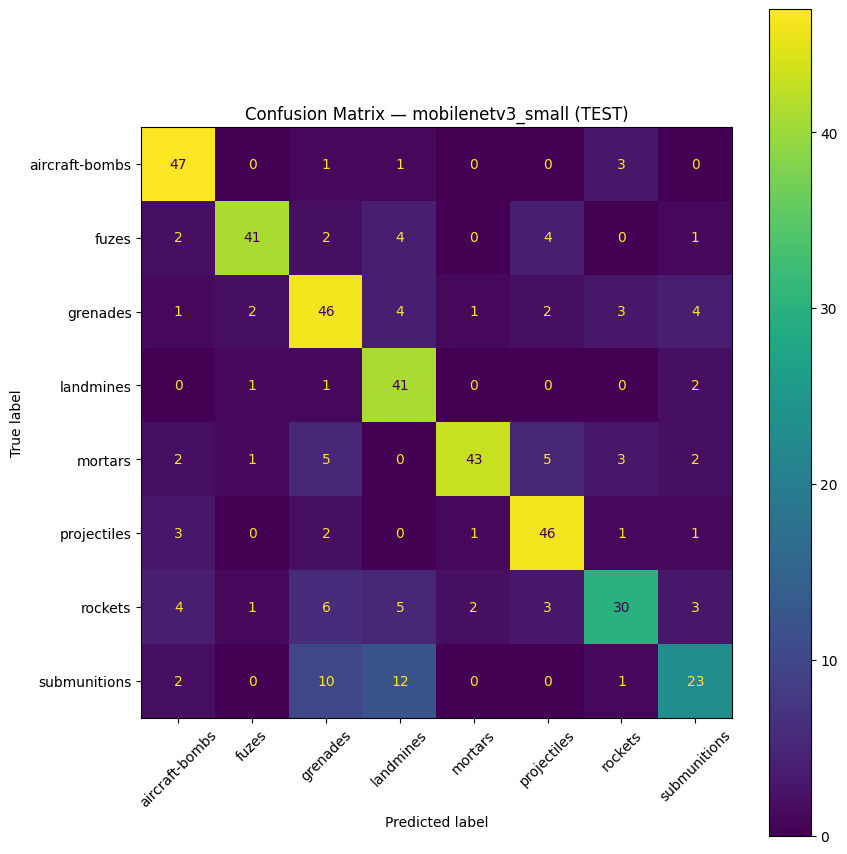

Saved confusion matrix -> runs/classify/uxord10k_mobilenetv3_small/eval/confusion_matrix.png


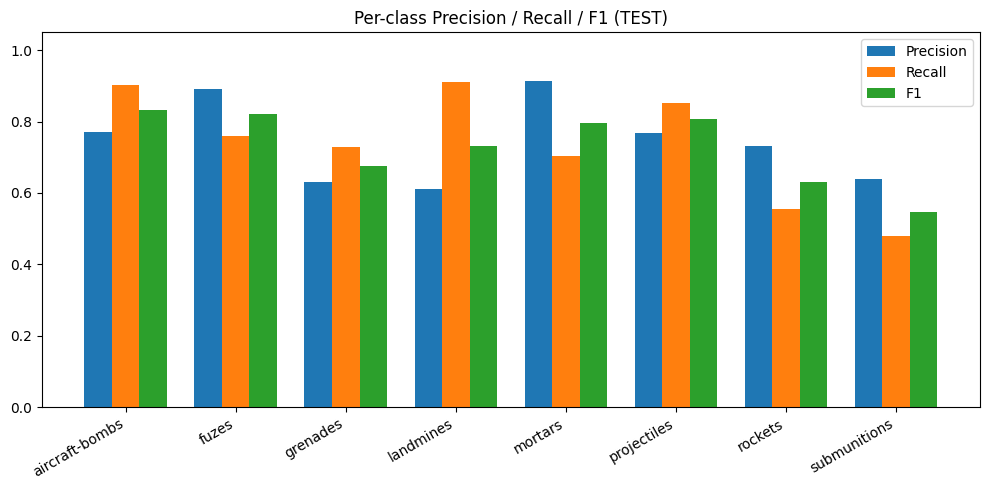

Saved per-class bars -> runs/classify/uxord10k_mobilenetv3_small/eval/per_class_bars.png


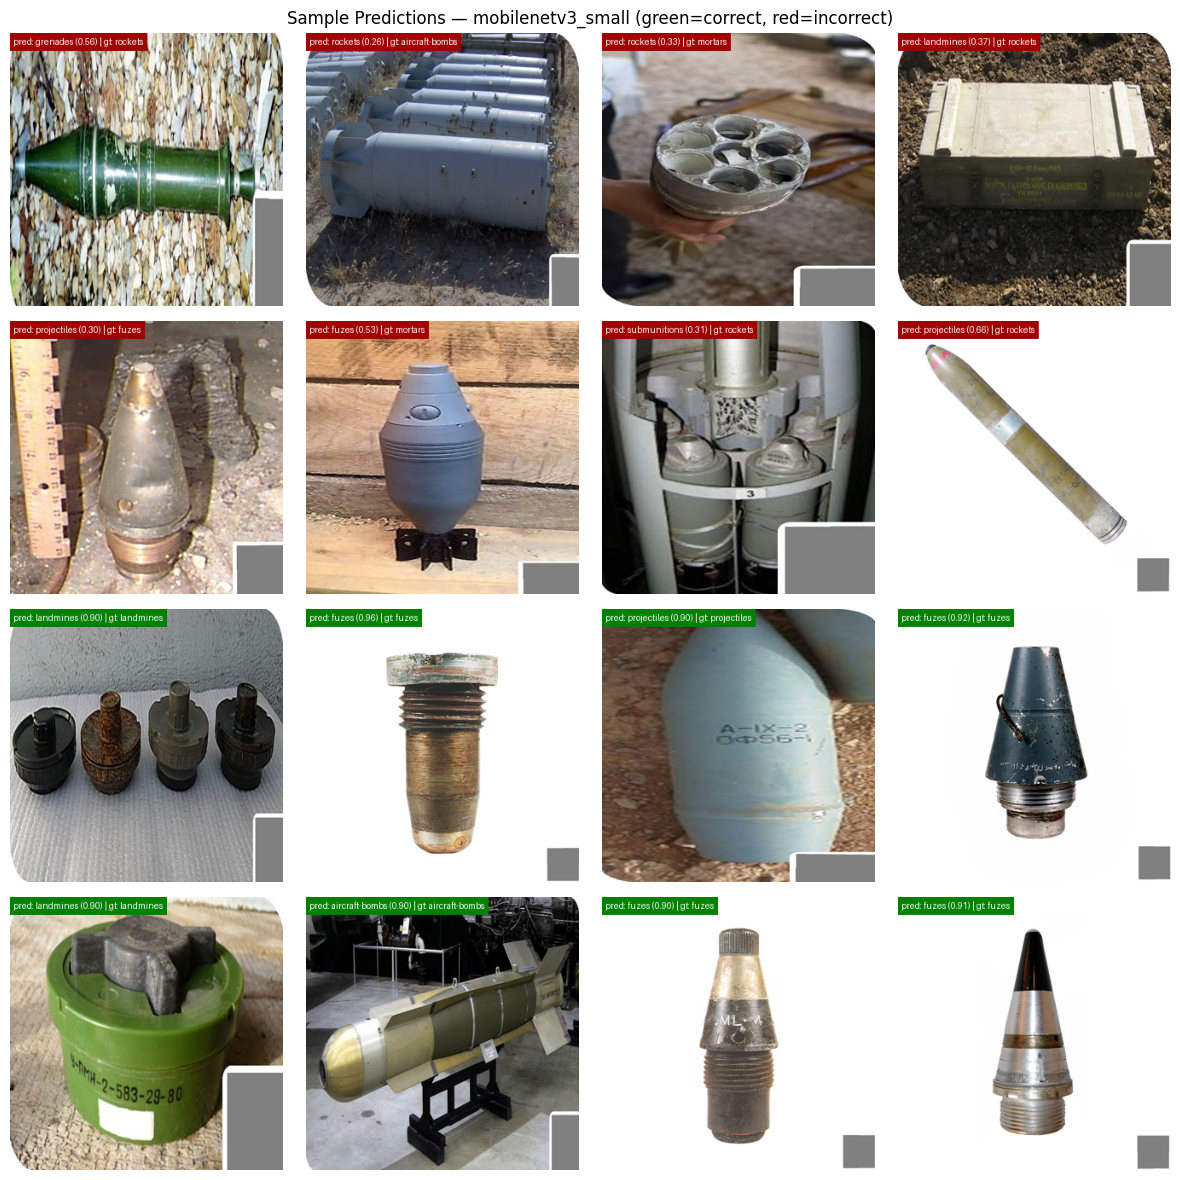

Saved prediction grid -> runs/classify/uxord10k_mobilenetv3_small/eval/prediction_grid.png

Artifacts:
  Run dir         : /content/runs/classify/uxord10k_mobilenetv3_small
  Best checkpoint : /content/runs/classify/uxord10k_mobilenetv3_small/best.pt
  Confusion matrix: /content/runs/classify/uxord10k_mobilenetv3_small/eval/confusion_matrix.png
  Per-class bars  : /content/runs/classify/uxord10k_mobilenetv3_small/eval/per_class_bars.png
  Grid            : /content/runs/classify/uxord10k_mobilenetv3_small/eval/prediction_grid.png
  Per-class CSV   : /content/runs/classify/uxord10k_mobilenetv3_small/eval/per_class_report.csv


In [11]:
# Evaluation + Visualization (MobileNetV3-Small / EfficientNet-B0 checkpoint)
# - Loads the BEST checkpoint saved by the training cell (OUT_DIR/best.pt)
# - Rebuilds the model (arch read from checkpoint), loads weights
# - Evaluates on TEST split and visualizes:
#     * Top-1 / Top-5 accuracy
#     * Per-class precision/recall/F1 (table + bars)
#     * Confusion matrix
#     * Prediction grid (green=correct, red=incorrect)
#
# Assumes dataset at:
#   /content/UXORD-10K/UXORD-10K-release/no-logos/{train,val,test}/{class}/*.jpg
# and a run directory like:
#   runs/classify/uxord10k_mobilenetv3_small (with best.pt inside)

import os, glob, math, random, warnings
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, accuracy_score,
                             top_k_accuracy_score, precision_recall_fscore_support)
warnings.filterwarnings("ignore")

# ----------------------- Config -----------------------
DATASET_DIR = "/content/UXORD-10K/UXORD-10K-release/no-logos"   # <-- change if needed
RUN_GLOB    = "runs/classify/uxord10k_*"                        # will pick latest run automatically
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
BATCH       = 128
WORKERS     = min(8, os.cpu_count() or 2)
SAMPLES_PER_GRID = 16

# --------------------- Find best.pt -------------------
run_dirs = sorted(glob.glob(RUN_GLOB), key=os.path.getmtime)
assert run_dirs, f"No run dirs matched {RUN_GLOB}"
RUN_DIR = Path(run_dirs[-1])
BEST_PT = RUN_DIR / "best.pt"
if not BEST_PT.exists():
    # Fallback: try checkpoints folder (if user copied there)
    ckpts = sorted(Path("checkpoints").glob(f"{RUN_DIR.name}_best_epoch*_top1_*.pt"), key=os.path.getmtime)
    assert ckpts, f"best.pt not found in {RUN_DIR}; no matching checkpoints in ./checkpoints/"
    BEST_PT = ckpts[-1]
EVAL_DIR = RUN_DIR / "eval"
EVAL_DIR.mkdir(parents=True, exist_ok=True)

print(f"Using run dir     : {RUN_DIR}")
print(f"Loading checkpoint: {BEST_PT}")

ckpt = torch.load(BEST_PT, map_location=DEVICE)
arch = ckpt.get("arch", "mobilenetv3_small")
saved_classes = ckpt.get("classes", None)
IMG_SIZE = int(ckpt.get("img_size", 320))

# ------------------- Rebuild model --------------------
def build_model(arch, num_classes):
    if arch == "mobilenetv3_small":
        weights = models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
        net = models.mobilenet_v3_small(weights=weights)
        in_feats = net.classifier[-1].in_features
        net.classifier[-1] = nn.Linear(in_feats, num_classes)
    elif arch == "efficientnet_b0":
        weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
        net = models.efficientnet_b0(weights=weights)
        in_feats = net.classifier[-1].in_features
        net.classifier[-1] = nn.Linear(in_feats, num_classes)
    else:
        raise ValueError(f"Unknown arch in checkpoint: {arch}")
    return net

# --------------------- Data (TEST) --------------------
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

eval_tfms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE * 1.14)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])
test_ds = datasets.ImageFolder(Path(DATASET_DIR) / "test", transform=eval_tfms)
CLASS_NAMES = test_ds.classes
NUM_CLASSES = len(CLASS_NAMES)
assert NUM_CLASSES >= 2, "Need at least 2 classes for evaluation."
if saved_classes is not None and list(saved_classes) != list(CLASS_NAMES):
    print("⚠️ WARNING: Classes in dataset differ from those saved in checkpoint.\n"
          f"   ckpt: {saved_classes}\n   ds  : {CLASS_NAMES}")

test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False,
                         num_workers=WORKERS, pin_memory=True)

# ------------------ Load weights ----------------------
model = build_model(arch, NUM_CLASSES).to(DEVICE)
model.load_state_dict(ckpt["model_state"])
model.eval()

# ------------------ Evaluate (TEST) -------------------
def topk_acc(output, target, k=5):
    with torch.no_grad():
        k = min(k, output.size(1))
        _, pred = output.topk(k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        return correct[:1].reshape(-1).float().sum().item(), correct[:k].reshape(-1).float().sum().item()

y_true, y_pred, y_probs = [], [], []
paths_iterated = []

with torch.no_grad():
    total, top1_sum, top5_sum = 0, 0.0, 0.0
    for bidx, (xb, yb) in enumerate(test_loader):
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True)
        out = model(xb)
        probs = torch.softmax(out, dim=1)

        t1, t5 = topk_acc(out, yb, k=min(5, NUM_CLASSES))
        top1_sum += t1
        top5_sum += t5
        total += xb.size(0)

        y_true.extend(yb.detach().cpu().tolist())
        y_pred.extend(out.argmax(1).detach().cpu().tolist())
        y_probs.extend(probs.detach().cpu().tolist())

        # collect file paths for visualization
        base = bidx * BATCH
        for j in range(xb.size(0)):
            idx = base + j
            if idx < len(test_ds.samples):
                paths_iterated.append(test_ds.samples[idx][0])

top1 = top1_sum / total
top5 = top5_sum / total
print(f"\nTEST — Top-1: {top1:.4f} | Top-5: {top5:.4f}")

# ---------------- Metrics & Reports -------------------
y_true_np = np.array(y_true)
y_pred_np = np.array(y_pred)
y_prob_np = np.array(y_probs)

sk_top1 = accuracy_score(y_true_np, y_pred_np)
sk_top5 = top_k_accuracy_score(y_true_np, y_prob_np, k=min(5, NUM_CLASSES), labels=list(range(NUM_CLASSES)))
print(f"Sklearn — Top-1: {sk_top1:.4f} | Top-5: {sk_top5:.4f}")

report_txt = classification_report(y_true_np, y_pred_np, target_names=CLASS_NAMES, digits=4)
print("\nPer-class metrics (TEST):\n" + report_txt)

# Save a CSV of the per-class table too
prec, rec, f1, sup = precision_recall_fscore_support(
    y_true_np, y_pred_np, labels=list(range(NUM_CLASSES)), zero_division=0
)
import pandas as pd
df_report = pd.DataFrame({
    "class": CLASS_NAMES,
    "precision": prec, "recall": rec, "f1": f1, "support": sup
})
df_report.to_csv(EVAL_DIR / "per_class_report.csv", index=False)
print(f"Saved per-class report CSV -> {EVAL_DIR/'per_class_report.csv'}")

# ---------------- Confusion Matrix --------------------
cm = confusion_matrix(y_true_np, y_pred_np, labels=list(range(NUM_CLASSES)))
fig_cm, ax_cm = plt.subplots(figsize=(9, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(ax=ax_cm, xticks_rotation=45, colorbar=True)
ax_cm.set_title(f"Confusion Matrix — {arch} (TEST)")
plt.tight_layout()
cm_path = EVAL_DIR / "confusion_matrix.png"
fig_cm.savefig(cm_path, dpi=200)
plt.show()
print(f"Saved confusion matrix -> {cm_path}")

# ----------- Per-class Precision/Recall/F1 bars -------
x = np.arange(NUM_CLASSES)
plt.figure(figsize=(10, 5))
plt.bar(x-0.25, prec, width=0.25, label='Precision')
plt.bar(x,      rec,  width=0.25, label='Recall')
plt.bar(x+0.25, f1,   width=0.25, label='F1')
plt.xticks(x, CLASS_NAMES, rotation=30, ha='right')
plt.ylim(0, 1.05)
plt.title("Per-class Precision / Recall / F1 (TEST)")
plt.legend()
plt.tight_layout()
bars_path = EVAL_DIR / "per_class_bars.png"
plt.savefig(bars_path, dpi=200)
plt.show()
print(f"Saved per-class bars -> {bars_path}")

# ---------------- Prediction Grid ---------------------
def load_image(path, size=IMG_SIZE):
    im = Image.open(path).convert("RGB")
    im = im.resize((size, size))
    return im

def draw_label(im, text, ok):
    draw = ImageDraw.Draw(im)
    w = draw.textlength(text); h = 12; pad = 4
    bg = (0,128,0) if ok else (160,0,0)
    draw.rectangle([0,0,w+2*pad,h+2*pad], fill=bg)
    draw.text((pad,pad), text, fill=(255,255,255))
    return im

idx_all   = np.arange(len(y_true_np))
idx_wrong = idx_all[y_true_np != y_pred_np]
idx_right = idx_all[y_true_np == y_pred_np]

sel = []
need = SAMPLES_PER_GRID
take_wrong = min(len(idx_wrong), need//2)
if take_wrong > 0:
    sel.extend(np.random.choice(idx_wrong, size=take_wrong, replace=False).tolist())
need -= len(sel)
if need > 0 and len(idx_right) > 0:
    sel.extend(np.random.choice(idx_right, size=min(need, len(idx_right)), replace=False).tolist())
sel = sel[:SAMPLES_PER_GRID]

cols = max(1, int(math.sqrt(SAMPLES_PER_GRID)))
rows = math.ceil(len(sel)/cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
axes = np.atleast_2d(axes)

for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    if i >= len(sel): continue
    j = sel[i]
    path = paths_iterated[j] if j < len(paths_iterated) else None
    gt   = CLASS_NAMES[y_true_np[j]]
    pr   = CLASS_NAMES[y_pred_np[j]]
    prob = float(np.max(y_prob_np[j])) if j < len(y_prob_np) else 0.0
    im = load_image(path, size=IMG_SIZE).copy() if path else Image.new("RGB",(IMG_SIZE,IMG_SIZE),(40,40,40))
    tag = f"pred: {pr} ({prob:.2f}) | gt: {gt}"
    im = draw_label(im, tag, pr==gt)
    ax.imshow(im)

plt.suptitle(f"Sample Predictions — {arch} (green=correct, red=incorrect)", y=0.98)
plt.tight_layout()
grid_path = EVAL_DIR / "prediction_grid.png"
plt.savefig(grid_path, dpi=200)
plt.show()
print(f"Saved prediction grid -> {grid_path}")

print("\nArtifacts:")
print("  Run dir         :", RUN_DIR.resolve())
print("  Best checkpoint :", Path(BEST_PT).resolve())
print("  Confusion matrix:", cm_path.resolve())
print("  Per-class bars  :", bars_path.resolve())
print("  Grid            :", grid_path.resolve())
print("  Per-class CSV   :", (EVAL_DIR/'per_class_report.csv').resolve())


## UI Implemmentation

In [12]:
import os, json, requests
import gradio as gr
import numpy as np
from PIL import Image, ImageDraw, ImageFont

# ========= Config =========
WEIGHTS = "/content/weights/best.pt"
CONF_THRESH = 0.25  # internal detector threshold (not shown to user)

# Demo override: force one detection regardless of image/model (set to None to disable)
FORCE_TYPE = "Landmine"      # try: "Grenade", "Mortar", "Rocket", "Submunition", ...
FORCE_CONF = 0.88

# OpenRouter model to use (fast + widely available)
llm_model_name = "meta-llama/llama-3.1-8b-instruct"
OPENROUTER_URL = "https://openrouter.ai/api/v1/chat/completions"

# ========= Load YOLO if available =========
MODEL = None
try:
    from ultralytics import YOLO
    if os.path.exists(WEIGHTS):
        MODEL = YOLO(WEIGHTS)
except Exception:
    MODEL = None

# Demo assets (used if no model or when forcing)
DEMO_PREDS_PATH = "/content/demo_predictions.json"
DEMO_PREDS = json.load(open(DEMO_PREDS_PATH)) if os.path.exists(DEMO_PREDS_PATH) else {}
SAMPLE_DIR = "/content/samples"

# ========= Helpers =========
def draw_boxes(pil_img, dets):
    img = pil_img.copy()
    d = ImageDraw.Draw(img)
    font = ImageFont.load_default()
    for det in dets:
        x1,y1,x2,y2 = det["bbox"]
        label = det.get("label","UXO")
        conf = det.get("conf",0.0)
        d.rectangle([x1,y1,x2,y2], outline=(255,0,0), width=3)
        tag = f"{label} {conf:.2f}"
        ty = max(0, y1-16)
        d.text((x1+5, ty), tag, fill=(255,255,255), font=font)
    return img

def risk_score(dets):
    if not dets: return 0.05
    avg_conf = sum([max(d.get("conf",0.3),0.1) for d in dets]) / len(dets)
    return float(min(1.0, 0.25 + 0.15*len(dets) + 0.6*avg_conf))

def class_counts_html(dets):
    counts = {}
    for d in dets:
        counts[d.get("label","UXO")] = counts.get(d.get("label","UXO"), 0) + 1
    if not counts:
        return "<span style='opacity:.8'>No detections.</span>"
    parts = [f"<code>{k}</code> × {v}" for k,v in sorted(counts.items(), key=lambda x:(-x[1],x[0]))]
    return " • ".join(parts)

def confidences_md(dets):
    if not dets: return "(none)"
    lines = [f"- {d.get('label','UXO')}: *{d.get('conf',0):.2f}*" for d in dets]
    return "\n".join(lines)

def yolo_infer(pil_img):
    detections = []
    r = MODEL.predict(source=np.array(pil_img), imgsz=640, conf=CONF_THRESH, verbose=False)[0]
    if getattr(r, "boxes", None) is None:
        return detections
    for b in r.boxes:
        xyxy = b.xyxy.cpu().numpy().astype(int)[0].tolist()
        c = float(b.conf.cpu().numpy()[0]) if b.conf is not None else 0.0
        cls_id = int(b.cls.cpu().numpy()[0]) if b.cls is not None else 0
        label = MODEL.names.get(cls_id, "UXO") if hasattr(MODEL,"names") else "UXO"
        detections.append({"bbox": xyxy, "label": label, "conf": c})
    return detections

# ========= LLM guidance via OpenRouter (mandatory, with safe fallback) =========
def llm_guidance(detections, risk):
    api_key = os.environ.get("OPENROUTER_API_KEY", "").strip()
    n = len(detections)
    classes = ", ".join(sorted({d.get("label","UXO") for d in detections})) or "None"
    conf_list = "; ".join([f"{d.get('label','UXO')}={d.get('conf',0):.2f}" for d in detections]) or "N/A"
    user_prompt = f"""
You are a concise UXO safety advisor for field engineers.

Detections: {n}
Classes: {classes}
Confidences: {conf_list}
Estimated risk: {int(risk*100)}%

Provide a SHORT, step-by-step plan (<=120 words):
1) Immediate action (safety-first; never touch or move objects).
2) How to mark & report (authorities/EOD), with location logging.
3) How to protect people & environment, and proceed with rebuilding (reroute/phase work).
"""

    if not api_key:
        # No key set—show clear message, but keep demo running
        return (
            "🧠 Simulated Guidance (fallback)\n\n"
            "No OpenRouter key set. Set OPENROUTER_API_KEY to enable live advice.\n\n"
            "1) Stop movement; never touch or move objects.\n"
            "2) Mark the area from a safe distance; log GPS/photos.\n"
            "3) Report to authorities/EOD; reroute works and restrict access until cleared.\n"
        )

    try:
        headers = {
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
            # Optional but good practice:
            "HTTP-Referer": "https://colab.research.google.com/",
            "X-Title": "UXO AI — Sustainable Clearance",
        }
        data = {
            "model": llm_model_name,
            "messages": [
                {"role":"system","content":"Give compact, practical UXO safety guidance. Never advise touching or moving suspected ordnance."},
                {"role":"user","content": user_prompt},
            ],
            "temperature": 0.2,
            "max_tokens": 220
        }
        r = requests.post(OPENROUTER_URL, headers=headers, json=data, timeout=30)
        r.raise_for_status()
        txt = r.json()["choices"][0]["message"]["content"].strip()
        return txt if txt else "⚠ LLM returned empty text. Try again."
    except Exception as e:
        # Stay demo-proof even if the LLM API errors or rate-limits
        r_pct = int(risk*100)
        return (
            "🧠 Guidance\n\n"
            f"Detected {n} potential UXO(s): {classes}\n"
            f"Estimated risk: {r_pct}%\n\n"
            "1) Stop movement; never touch or move objects.\n"
            "2) Mark the area from a safe distance; log GPS/photos.\n"
            "3) Report to authorities/EOD; reroute works and restrict access until cleared.\n"
        )

# ========= Pipeline =========
def infer(image, sample_name):
    if image is None and sample_name:
        image = np.array(Image.open(os.path.join(SAMPLE_DIR, sample_name)).convert("RGB"))
    if image is None:
        return None, "Upload an image or pick a sample."

    pil = Image.fromarray(image).convert("RGB")

    # 1) detections (model or demo)
    if MODEL is not None:
        dets = yolo_infer(pil)
    else:
        key = sample_name if sample_name in DEMO_PREDS else ("sample_uxo.png" if image.mean() < 140 else "sample_clean.png")
        dets = DEMO_PREDS.get(key, [])

    # 2) optional demo override (force a class)
    if FORCE_TYPE:
        H, W = image.shape[:2]
        x1, y1 = int(W*0.35), int(H*0.30)
        x2, y2 = int(W*0.65), int(H*0.70)
        dets = [{"bbox":[x1,y1,x2,y2], "label": FORCE_TYPE, "conf": float(FORCE_CONF)}]

    # 3) scoring & render
    r = risk_score(dets)
    annotated = draw_boxes(pil, dets)

    header = f"*Detections:* {len(dets)}  •  *Estimated risk:* {int(r*100)}%"
    classes = class_counts_html(dets)
    confs = confidences_md(dets)

    # 4) LLM advice (OpenRouter or fallback)
    advice = llm_guidance(dets, r)

    details = (
        f"{header}\n\n"
        f"*Classes*: {classes}\n\n"
        f"*Detection confidences*\n{confs}\n\n"
        f"{advice}\n\n"
        f"Prototype only. Never approach suspected UXOs; contact local authorities/EOD."
    )
    return np.array(annotated), details

# ========= Interface =========
with gr.Blocks(title="UXO AI – Sustainable Clearance") as app:
    gr.Markdown("""
    <div style="padding:18px;border-radius:14px;border:1px solid #e5e7eb;background:linear-gradient(180deg,#ffffff,#fafafa);">
      <h1 style="margin:0 0 8px 0;font-size:32px;">🧭 UXO AI — Sustainable Clearance</h1>
      <p style="margin:0;font-size:17px;line-height:1.55;">
        <b>Aim:</b> Detect potential Unexploded Ordnance (UXO) from imagery and provide clear, AI-generated safety steps
        to help teams mark, report, and plan safe, sustainable rebuilding.
        <i>Prototype only — never approach suspected UXOs.</i>
      </p>
    </div>
    """)
    with gr.Row():
        with gr.Column(scale=2):
            img = gr.Image(type="numpy", label="Upload aerial/ground image")
            sample = gr.Dropdown(choices=["","sample_uxo.png","sample_clean.png"], value="", label="Or pick a sample")
            btn = gr.Button("Analyze", variant="primary")
        with gr.Column(scale=2):
            out_img = gr.Image(label="Annotated result")
            out_txt = gr.Markdown()

    btn.click(infer, inputs=[img, sample], outputs=[out_img, out_txt])

# Let Gradio pick a free port automatically
app.launch(share=True, show_error=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://88239422e675cf3528.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
